In [1]:
import sqlite3
import pandas as pd
import os


conn = sqlite3.connect('/Users/dicordova/Documents/USFQ Data Science/Fundamentos/Proyecto FDS/notebooks/mydatabase.db')
query = "SELECT DISTINCT provincia FROM df_encoded"
provincia = pd.read_sql_query(query, conn)
print(provincia)
conn.close()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
   provincia
0          5
1          6
2         12
3         13
4         17
5         18
6         23


In [2]:
import sqlite3
import pandas as pd

# Connect to your database
conn = sqlite3.connect('/Users/dicordova/Documents/USFQ Data Science/Fundamentos/Proyecto FDS/notebooks/mydatabase.db')

# Define the SQL query to load only one province (replace 'Pichincha' with the province you want)
query = """
SELECT * FROM df_encoded
WHERE provincia = '5'
ORDER BY RANDOM()
LIMIT 1000
"""

# Load the filtered data into a DataFrame
cotopaxi_df = pd.read_sql_query(query, conn)

# Preview the result
print(cotopaxi_df.head())

conn.close()


   provincia  canton_id  nro_vivienda  nro_hogar  espacio_cocina  \
0          5          2        4852.0        1.0             1.0   
1          5          2       20488.0        1.0             2.0   
2          5          4       27766.0        1.0             1.0   
3          5          2        2270.0        NaN             NaN   
4          5          4        6028.0        1.0             1.0   

   tiene_inodoro  tiene_ducha  combustible_cocina  fuente_agua_bebida  \
0            1.0          1.0                 3.0                 2.0   
1            3.0          3.0                 1.0                 1.0   
2            1.0          1.0                 1.0                 1.0   
3            NaN          NaN                 NaN                 NaN   
4            1.0          1.0                 4.0                 6.0   

   separa_basura_reciclaje  ...  ocup_viv_part_r_label_Ocupada  \
0                      2.0  ...                              1   
1                   

In [3]:
# Show all columns in output
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

cols_info = pd.DataFrame({
    'column': cotopaxi_df.columns,
    'dtype': cotopaxi_df.dtypes.values
})
print(cols_info.sort_values(by='dtype'))


                                                column    dtype
0                                            provincia    int64
146        tipo_vivienda_label_Otra vivienda colectiva    int64
147       tipo_vivienda_label_Otra vivienda particular    int64
148                         tipo_vivienda_label_Rancho    int64
149  tipo_vivienda_label_Residencia de adultos mayo...    int64
..                                                 ...      ...
29                                       total_mujeres  float64
27                                      nro_emigrantes  float64
41                                           mat_techo  float64
40                                     ocup_viv_colect   object
34                                            id_hogar   object

[230 rows x 2 columns]


In [4]:
with open('columns.txt', 'w') as f:
    for col in cotopaxi_df.columns:
        f.write(col + '\n')


Creamos un file de las columnas porque son muchas y el output sale truncado cada vez que intentamos explorarla para familiarizarnos con los nombres. 

In [5]:

# Create the summary DataFrame
col_info = pd.DataFrame({
    'Column Name': cotopaxi_df.columns,
    'Data Type': cotopaxi_df.dtypes.values,
    'Missing Values': cotopaxi_df.isna().sum().values
})

# Save it to a text file (tab-separated for readability)
col_info.to_csv('columns_info.txt', sep='\t', index=False)

# Optional: Preview in notebook
print(col_info)


                                           Column Name Data Type  \
0                                            provincia     int64   
1                                            canton_id     int64   
2                                         nro_vivienda   float64   
3                                            nro_hogar   float64   
4                                       espacio_cocina   float64   
..                                                 ...       ...   
225                   nro_cuartos_r_label_Tres cuartos     int64   
226                      nro_cuartos_r_label_Un cuarto     int64   
227     deficit_habitacional_label_Dignas o aceptables     int64   
228  deficit_habitacional_label_Déficit cualitativo...     int64   
229  deficit_habitacional_label_Déficit cuantitativ...     int64   

     Missing Values  
0                 0  
1                 0  
2                 0  
3               197  
4               198  
..              ...  
225               0  
226    

In [5]:
cols_a_remover = [col for col in cotopaxi_df.columns if (
    col.startswith('nro_cuartos_r_label_') or
    col.startswith('nro_emigrantes_label') or
    col.startswith('nro_hogar_label') or
    col.startswith('separa_basura') or
    col.startswith('fallecidos_ultimos_3_anios_label')
)]

cotopaxi_df = cotopaxi_df.drop(columns=cols_a_remover)


Después de sacar ciertas columnas, vamos a imputar los valores faltantes de las variables numéricas útiles para nuestro índice con KNN imputer. 

In [7]:
from sklearn.impute import KNNImputer

def imputar_knn_variables(cotopaxi_df, variables, n_neighbors=5):
    """
    Imputes missing values in the specified numerical columns using KNN.

    Parameters:
    - cotopaxi_df: pandas DataFrame
    - variables: list of column names to impute
    - n_neighbors: number of neighbors for KNNImputer (default: 5)

    Returns:
    - A DataFrame with the selected variables imputed.
    """
    cotopaxi_df = cotopaxi_df.copy()
    
    # Ensure all columns exist
    missing_cols = [col for col in variables if col not in cotopaxi_df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not in the DataFrame: {missing_cols}")
    
    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    cotopaxi_df[variables] = imputer.fit_transform(cotopaxi_df[variables])
    
    return cotopaxi_df





In [8]:
variables_to_impute = [
    'nro_emigrantes',
    'total_personas_x',
    'nro_cuartos_r',
    'total_hombres',
    'total_mujeres',
    'nro_dormitorios_r'
]

cotopaxi_df = imputar_knn_variables(cotopaxi_df, variables_to_impute, n_neighbors=5)

Despues de la imputacion, vamos a sacar todos los valores NAN. Esta opcion se toma porque al haber imputado los valores ausentes en las variables numericas, podríamos usar el modo para las categóricas, pero no hay suficiente investigación para justificar esta decisión. Por lo tanto para el ejercicio las borraremos. 

In [9]:
cotopaxi_df_clean = cotopaxi_df.dropna().reset_index(drop=True)


Usamos KNN imputer para las variables numericas que usaremos en el modelo y en la construccion de variables compuestas. 

Creamos y combinamos varialbes en indicadores
Empezamos con hacinamiento. 

In [10]:
import numpy as np

# Evita división por cero o nulos
cotopaxi_df['personas_por_cuarto'] = cotopaxi_df['total_personas_x'] / cotopaxi_df['nro_cuartos_r']
cotopaxi_df['personas_por_cuarto'] = cotopaxi_df['personas_por_cuarto'].replace([np.inf, -np.inf], np.nan)

# Crear categoría de hacinamiento
cotopaxi_df['hacinamiento'] = np.select(
    [
        cotopaxi_df['personas_por_cuarto'] <= 2,
        (cotopaxi_df['personas_por_cuarto'] > 2) & (cotopaxi_df['personas_por_cuarto'] < 4),
        cotopaxi_df['personas_por_cuarto'] >= 4
    ],
    ['Aceptable', 'Moderado', 'Severo'],
    default='Desconocido'
)


In [11]:
hacinamiento_map = {'Aceptable': 0, 'Moderado': 1, 'Severo': 2, 'Desconocido': np.nan}
cotopaxi_df['hacinamiento_score'] = cotopaxi_df['hacinamiento'].map(hacinamiento_map)
print(cotopaxi_df[['hacinamiento', 'hacinamiento_score']].head(10))

  hacinamiento  hacinamiento_score
0    Aceptable                 0.0
1    Aceptable                 0.0
2    Aceptable                 0.0
3    Aceptable                 0.0
4    Aceptable                 0.0
5    Aceptable                 0.0
6    Aceptable                 0.0
7    Aceptable                 0.0
8    Aceptable                 0.0
9    Aceptable                 0.0


In [12]:
# Definir las columnas que indican vulnerabilidad
cols_vulnerables = [
    # Materiales precarios
    'mat_techo_label_Palma, paja u hoja',
    'mat_techo_label_Otro material',
    'mat_paredes_label_Caña no revestida',
    'mat_paredes_label_Adobe o tapia',
    'mat_paredes_label_Otro material',
    'mat_piso_label_Tierra',
    'mat_piso_label_Caña sin tratar',
    'mat_piso_label_Otro material',

    # Estados "Malos"
    'estado_techo_label_Malo',
    'estado_paredes_label_Malo',
    'estado_piso_label_Malo',

    # Ocupación inestable
    'ocup_viv_part_label_De temporada o vacacional',
    'ocup_viv_part_label_Ocupada con personas ausentes',
    'ocup_viv_colect_label_Sin residentes habituales'
]

# Asegurarnos de que las columnas existen
cols_vulnerables = [col for col in cols_vulnerables if col in cotopaxi_df.columns]

# Sumar como score
cotopaxi_df['vulnerabilidad_vivienda'] = cotopaxi_df[cols_vulnerables].sum(axis=1)


In [13]:
cotopaxi_df['nivel_vulnerabilidad_vivienda'] = pd.cut(
    cotopaxi_df['vulnerabilidad_vivienda'],
    bins=[-1, 1, 3, 5, np.inf],
    labels=['Baja', 'Media-baja', 'Media-alta', 'Alta']
)
print(cotopaxi_df[['vulnerabilidad_vivienda', 'nivel_vulnerabilidad_vivienda']].head(10))

   vulnerabilidad_vivienda nivel_vulnerabilidad_vivienda
0                        0                          Baja
1                        3                    Media-baja
2                        0                          Baja
3                        1                          Baja
4                        0                          Baja
5                        0                          Baja
6                        0                          Baja
7                        0                          Baja
8                        1                          Baja
9                        0                          Baja


In [14]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

cotopaxi_df_clean = remove_outliers_iqr(cotopaxi_df, ['vulnerabilidad_vivienda', 'personas_por_cuarto', 'hacinamiento_score'])


In [15]:
print("Antes de remover outliers:", cotopaxi_df.shape)
print("Después de remover outliers:", cotopaxi_df_clean.shape)


Antes de remover outliers: (1000, 223)
Después de remover outliers: (857, 223)


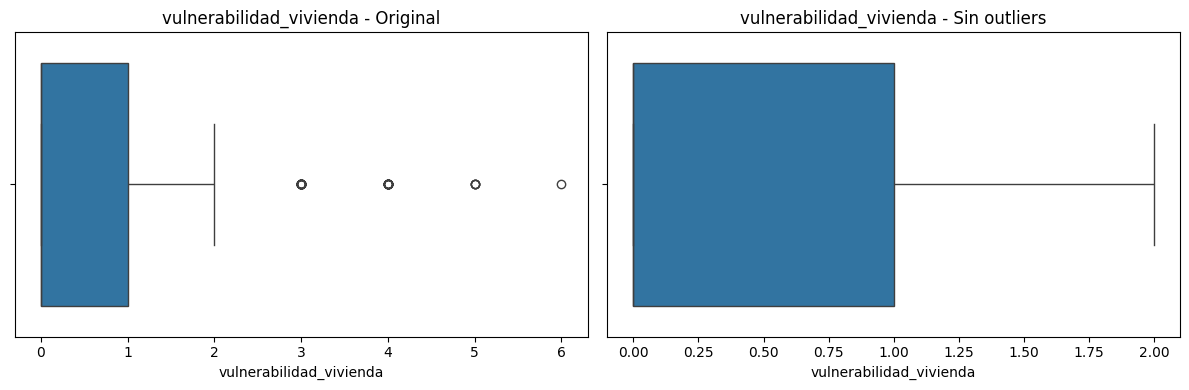

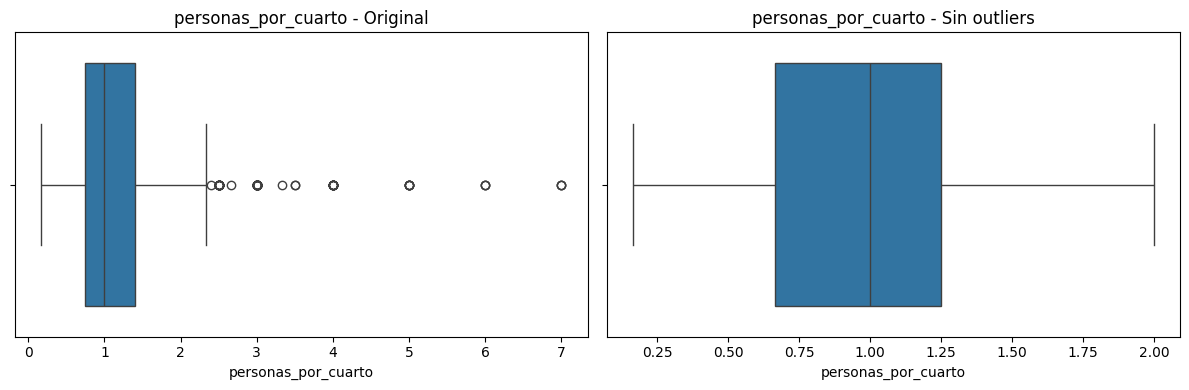

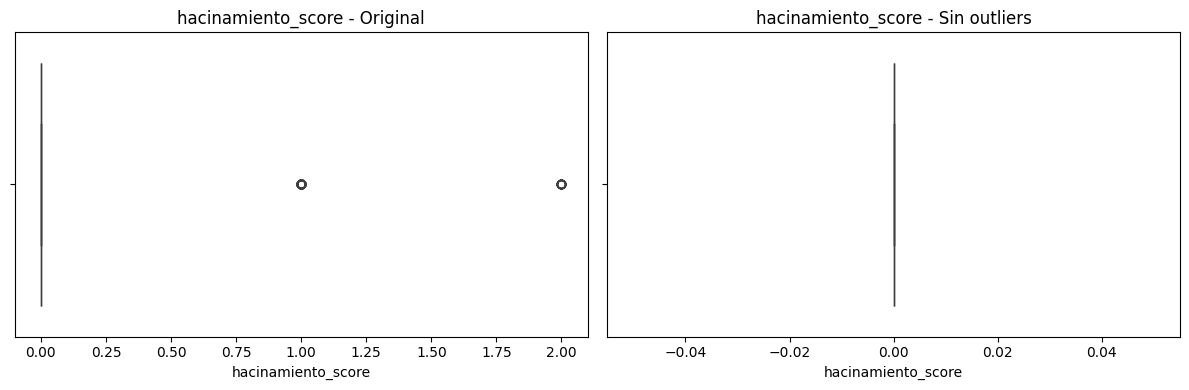

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

variables = ['vulnerabilidad_vivienda', 'personas_por_cuarto', 'hacinamiento_score']

for var in variables:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.boxplot(x=cotopaxi_df[var], ax=axes[0])
    axes[0].set_title(f'{var} - Original')

    sns.boxplot(x=cotopaxi_df_clean[var], ax=axes[1])
    axes[1].set_title(f'{var} - Sin outliers')

    plt.tight_layout()
    plt.show()


Esta transformación se hizo para: 
Para resumir vulnerabilidad en 4 niveles simples.

Para visualización (gráficos de barras, mapas coropléticos).

Para perfilar clusters usando métodos no supervisados.

In [13]:
from sklearn.preprocessing import StandardScaler

# Selecciona las variables que representan vulnerabilidad
variables_cluster = [
    'vulnerabilidad_vivienda',
    'personas_por_cuarto',
    'hacinamiento_score'
]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cotopaxi_df[variables_cluster])


In [ ]:
from sklearn.cluster import KMeans

# Inicializa KMeans con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cotopaxi_df['cluster_kmeans'] = kmeans.fit_predict(X_scaled)


/Users/dicordova/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dicordova/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [ ]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=4)
cotopaxi_df['cluster_agglo'] = agglo.fit_predict(X_scaled)
